In [4]:
import numpy as np
import xarray as xr
import pandas as pd
import netCDF4 as nc
import matplotlib.pyplot as plt
import sys
import numpy as np
import matplotlib as mpl
from mpl_toolkits.basemap import Basemap
import time
from datetime import datetime
from scipy import interpolate
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt
import matplotlib.colors
import json

In [7]:
# Considering to have them locally saved, otherwise follow "THESIS Dataset" Notebook
days70_from_april_1997_velocity_u_OK = xr.open_dataset("/mnt/iscsi2/OceanParcels/InputObsDom/days100_from_april_1997_velocity_u_OK.nc")
days70_from_april_1997_velocity_v_OK = xr.open_dataset("/mnt/iscsi2/OceanParcels/InputObsDom/days100_from_april_1997_velocity_v_OK.nc")

In [8]:
# Following the same approach of "THESIS Dataset" Notebook
    # To represent the bathymetry

base_url = 'https://dap.ceda.ac.uk/thredds/dodsC/bodc/UOX220077/WINDS-M/1997/WINDS-M_SFC_1997.nc'

ds_complete_hh = xr.open_dataset(base_url)
clipped_ds_hh = ds_complete_hh.sel(y_rho=slice(680, 986), x_rho=slice(150, 451),
                          y_u=slice(680, 986), x_u=slice(150, 451),
                          y_v=slice(680, 986), x_v=slice(150, 451))

fifteen_j_ds_hh = clipped_ds_hh.isel(time_counter=slice(0, 721)) 
clipped_velocity = fifteen_j_ds_hh.drop_vars(['s_w','hc','s_rho',
                                 'theta_s','theta_b','Tcline','Vtransform','f','pm','pn','lon_rho','lat_rho',
                                  'angle','mask_rho', 'Cs_r','sc_r','Cs_w','lon_u','lon_v','lat_u', 'lat_v',
                                  'sc_w'])

OSError: [Errno -90] NetCDF: file not found: b'https://dap.ceda.ac.uk/thredds/dodsC/bodc/UOX220077/WINDS-M/1997/WINDS-M_SFC_1997.nc'

In [9]:
extent_thin = [38.5, 41.5,-4.48427153 , -10.5289526]

**Plot Bathymetry**

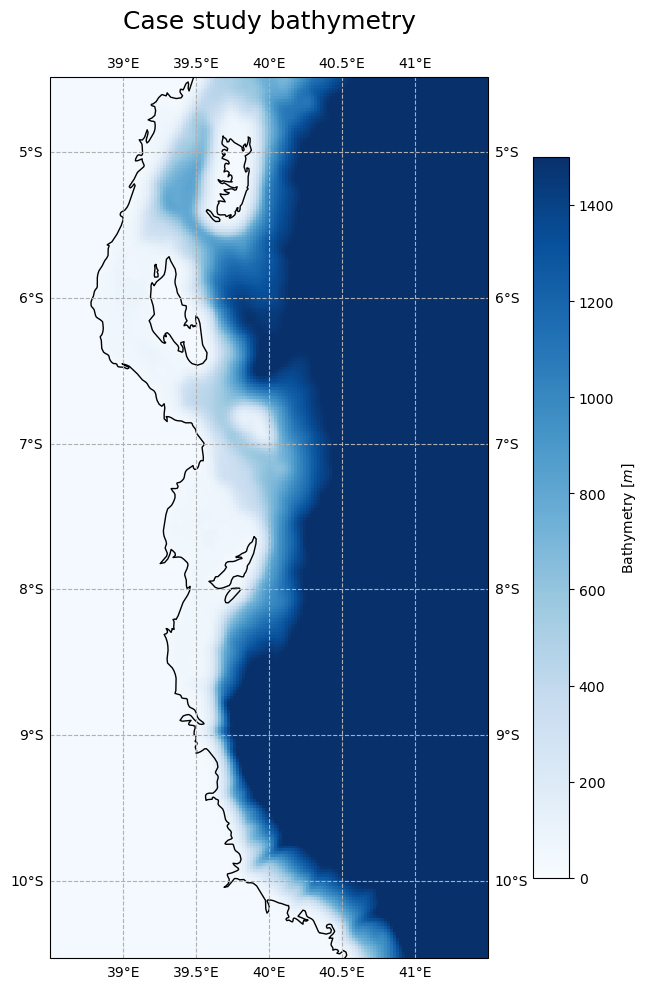

In [24]:
# Define the 'Blues' colormap
cmap = plt.cm.Blues

# Function to create a custom colormap with denser lower range
def create_custom_blues_colormap(cmap, transition_value, max_value):
    n = 256  # Number of points in the colormap
    
    # Create a list of colors from the 'Blues' colormap
    colors = cmap(np.linspace(0, 1, n))
    
    # Create a custom scale
    scale = np.concatenate([
        np.linspace(0, transition_value / max_value, int(n * (transition_value / max_value))),
        np.linspace(transition_value / max_value, 1, int(n * (1 - transition_value / max_value)))
    ])
    
    # Create a custom colormap
    new_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('custom_blues', colors[scale.argsort()])
    
    return new_cmap

# Create the custom colormap
transition_value = 100
max_value = 1500
custom_blues_cmap = create_custom_blues_colormap(cmap, transition_value, max_value)

plt.figure(figsize=(10, 10))

ax = plt.axes(projection=ccrs.PlateCarree())

# Invert the y-axis for imshow plot
extent_inverted_y = [clipped_velocity['nav_lon_rho'][0, 0], clipped_velocity['nav_lon_rho'][0, -1],
                     clipped_velocity['nav_lat_rho'][0, 0], clipped_velocity['nav_lat_rho'][-1, 0]]

im = ax.imshow(clipped_velocity['h'], origin='lower', extent=extent_inverted_y,
               cmap=custom_blues_cmap, interpolation='nearest', transform=ccrs.PlateCarree(), vmin=0, vmax=max_value)

ax.coastlines()
ax.gridlines(draw_labels=True, linestyle='--')
ax.set_extent(extent_thin, crs=ccrs.PlateCarree())

cbar = plt.colorbar(im, ax=ax, orientation='vertical', fraction=0.04, pad=0.05)
cbar.set_label('Bathymetry $[m]$')

plt.title('Case study bathymetry', fontsize=18, pad=20)

plt.tight_layout()

filename=f'/mnt/iscsi2/OceanParcels/OBS_Figures/Bathymetry_Tanz.png'
plt.savefig(filename)

**Plot Case study domain**

In [10]:
real_domain = [37.62, 43.62, -4.47430229, -10.51912117]
real_domain_plusone = [37.62-1, 43.62+1, -4.47430229+1, -10.51912117-1]

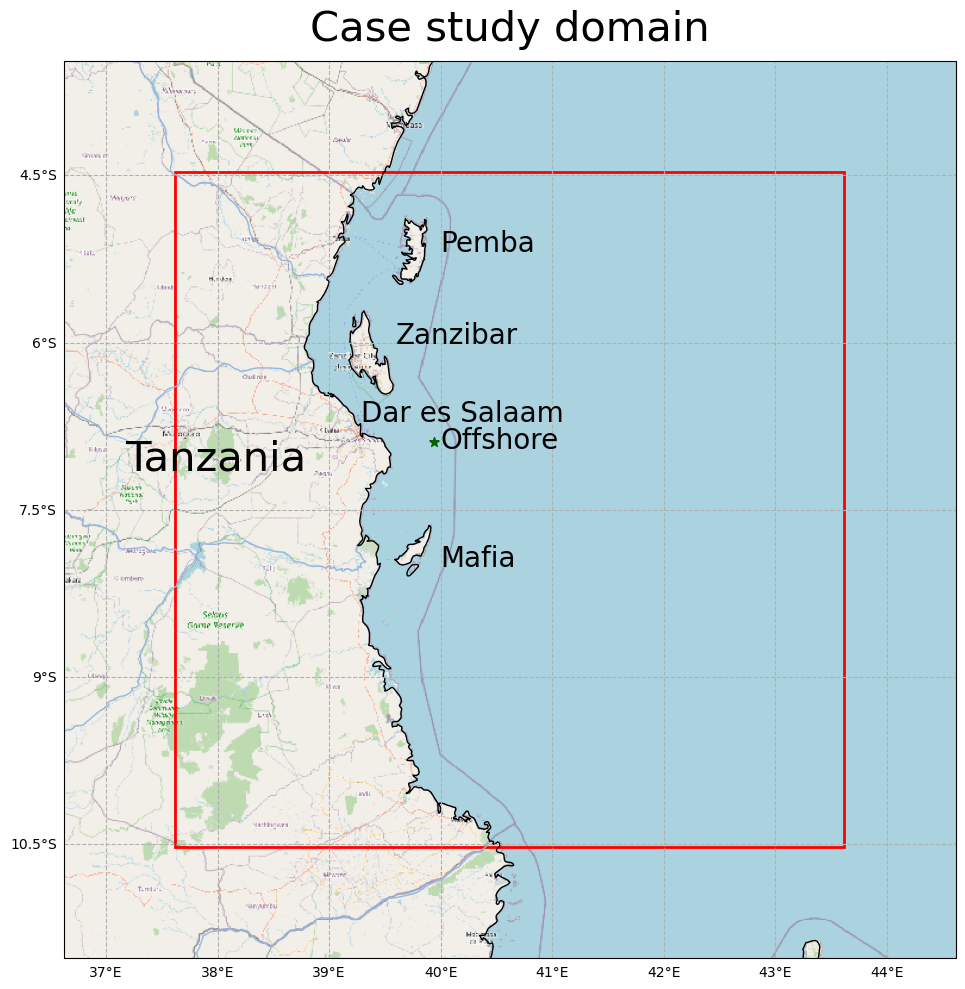

In [12]:
# Create a figure and axis with the specified projection
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set the extent of the map
ax.set_extent(real_domain_plusone, crs=ccrs.PlateCarree())

# Add CartoDB Positron tiles
cartodb_tiles = cimgt.OSM()
ax.add_image(cartodb_tiles, 8)  # Zoom level 8

# Add Natural Earth coastlines with high resolution
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'coastline', '10m',
                                           edgecolor='black', linewidth=1, facecolor='none'))

# Add other Natural Earth features if needed (e.g., land, borders, rivers)
#ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.RIVERS)

# Add gridlines and labels
gl = ax.gridlines(draw_labels=True, linestyle='--')
gl.right_labels = False
gl.top_labels = False

# Define the rectangle's bottom-left and top-right corners
rectangle_bottom_left = [real_domain[0], real_domain[2]]
rectangle_width = real_domain[1] - real_domain[0]
rectangle_height = real_domain[3] - real_domain[2]

# Create and add the red rectangle to the plot
rect = matplotlib.patches.Rectangle((rectangle_bottom_left[0], rectangle_bottom_left[1]), rectangle_width, rectangle_height,
                 linewidth=2, edgecolor='red', facecolor='none', transform=ccrs.PlateCarree())
ax.add_patch(rect)

ax.text(37.17, -7.14, 'Tanzania', transform=ccrs.PlateCarree(), fontsize=30, color='k')
ax.text(40, -8, 'Mafia', transform=ccrs.PlateCarree(), fontsize=20, color='k')
ax.text(39.6, -6, 'Zanzibar', transform=ccrs.PlateCarree(), fontsize=20, color='k')
ax.text(40, -5.18, 'Pemba', transform=ccrs.PlateCarree(), fontsize=20, color='k')
ax.text(39.29, -6.7, 'Dar es Salaam', transform=ccrs.PlateCarree(), fontsize=20, color='k')
ax.text(40 , -6.94461374, 'Offshore', transform=ccrs.PlateCarree(), fontsize=20, color='k')
ax.scatter(39.9375 , -6.89461374, s=50, transform=ccrs.PlateCarree(), color='darkgreen', marker='*')





# Add a title to the plot
plt.title("Case study domain", fontsize=30, pad=15)


plt.tight_layout()

filename=f'/mnt/iscsi2/OceanParcels/OBS_Figures/Case_study_domain_redrect.png'
plt.savefig(filename)

**Plot Trajectories as an example for April and November**

**Plot comparison connectivity matrix**
All years at a fixed pld and fixed month 

In [30]:
# Considering the connectivity matrix after 7 days for April 1997
connectivity_matrix_April97_7days = np.load('/mnt/iscsi2/OceanParcels/Analysis_ObsDom/connectivity_matrix_April97_7days.npy')
row_sums = np.nansum(connectivity_matrix_April97_7days, axis=1, keepdims=True)
connectivity_matrix_April97_7days = ( connectivity_matrix_April97_7days/ row_sums) * 100

In [31]:
# Considering the connectivity matrix after 7 days for April 1998
connectivity_matrix_April98_7days = np.load('/mnt/iscsi2/OceanParcels/Analysis_ObsDom/connectivity_matrix_April98_7days.npy')
row_sums = np.nansum(connectivity_matrix_April98_7days, axis=1, keepdims=True)
connectivity_matrix_April98_7days = ( connectivity_matrix_April98_7days/ row_sums) * 100

In [32]:
# Considering the connectivity matrix after 7 days for April 1999
connectivity_matrix_April99_7days = np.load('/mnt/iscsi2/OceanParcels/Analysis_ObsDom/connectivity_matrix_April99_7days.npy')
row_sums = np.nansum(connectivity_matrix_April99_7days, axis=1, keepdims=True)
connectivity_matrix_April99_7days = ( connectivity_matrix_April99_7days/ row_sums) * 100

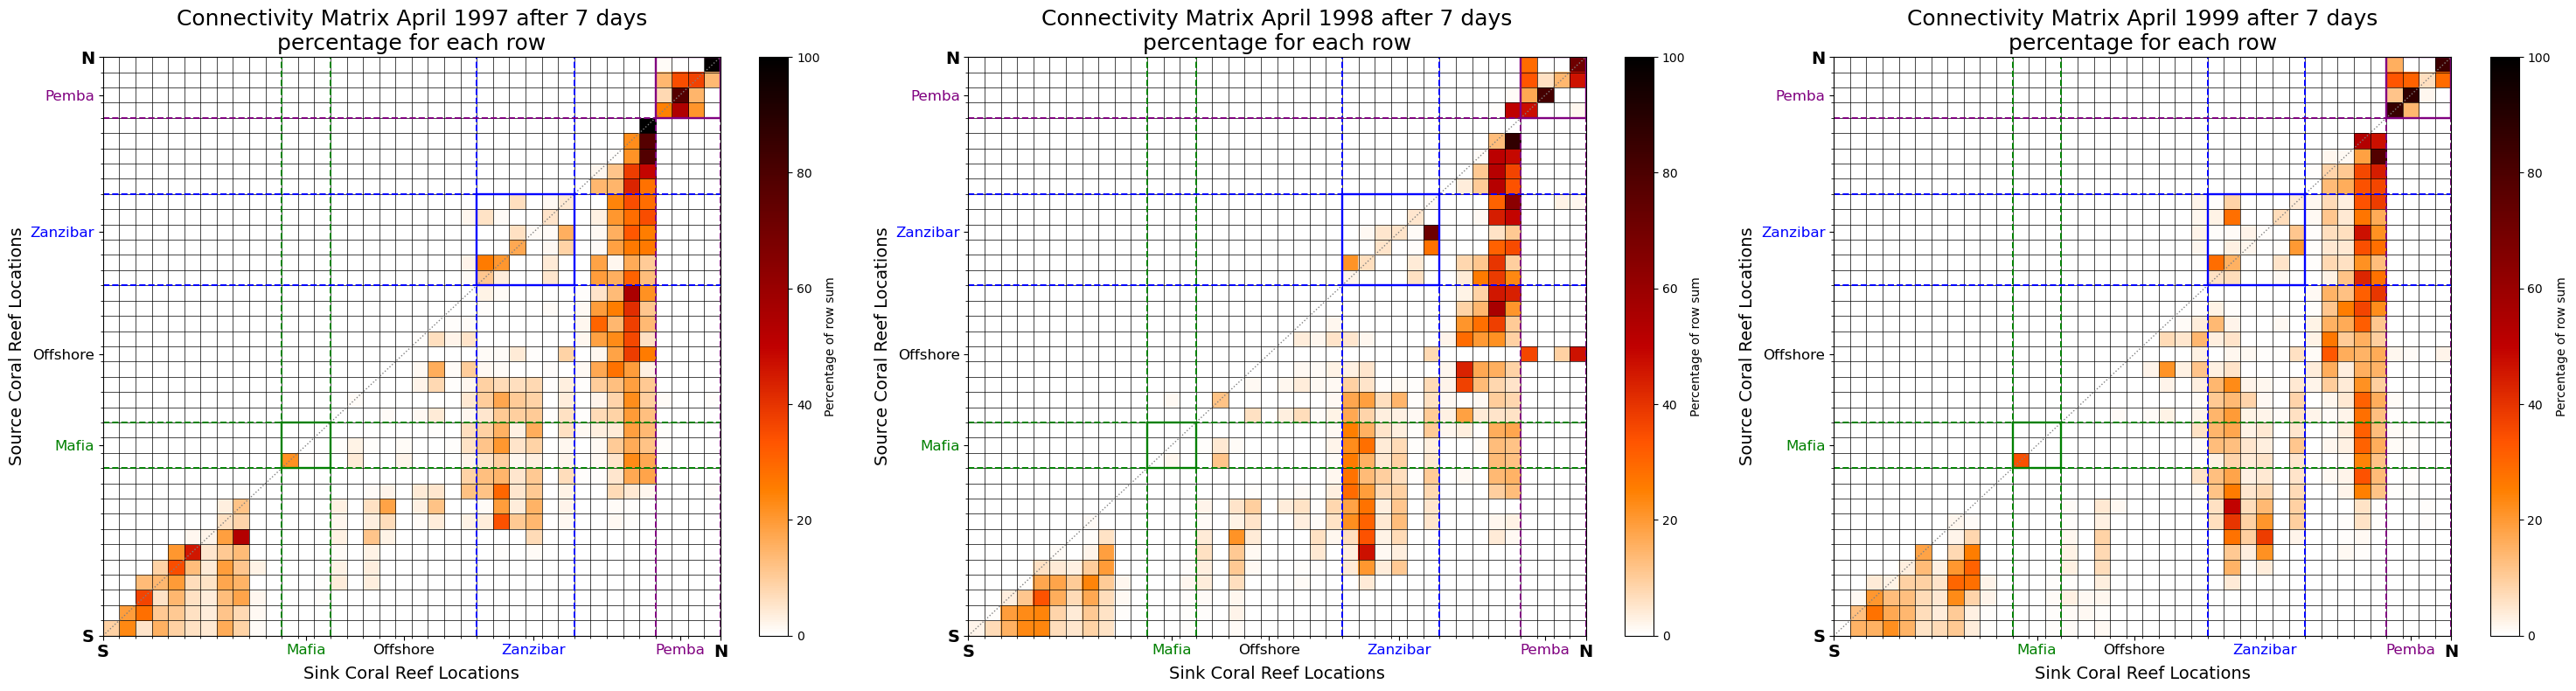

In [33]:
cmap = 'gist_heat_r'
vmax = 100
vmin = 0
specific_ticks = [-0.5, 12, 18, 26, 35, 37.5]
tick_labels = ['S', 'Mafia', 'Offshore', 'Zanzibar', 'Pemba', 'N']
tick_colors = {'S': 'black', 'Mafia': 'g', 'Offshore': 'k', 'Zanzibar': 'b', 'Pemba': 'purple', 'N': 'black'}
Mafia = [11, 14]
Zanzibar = [23, 29]
Pemba_rows = [34, 38]

fig, axs = plt.subplots(1, 3, figsize=(30, 8))

def plot_connectivity_matrix(ax, matrix, title):
    im = ax.imshow(matrix, cmap=cmap, interpolation='nearest', aspect='auto', vmax=vmax, vmin=vmin)
    ax.invert_yaxis()
    ax.set_title(title, fontsize=18)
    ax.set_xlabel('Sink Coral Reef Locations', fontsize=14)
    ax.set_ylabel('Source Coral Reef Locations', fontsize=14)
    ax.grid(which='minor', color='k', linestyle='-', linewidth=0.5)
    ax.set_xticks(np.arange(-0.5, 38.5, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, 38.5, 1), minor=True)
    ax.plot([-0.5, 37.5], [-0.5, 37.5], color='grey', linewidth=1, linestyle='dotted')

   
    for row in Mafia:
        ax.axhline(y=row - 0.5, color='g', linewidth=1.4, linestyle='--')
        ax.axhline(y=row - 0.5, xmin=11/38, xmax=14/38, color='g', linewidth=1.7, linestyle='-')
        ax.axvline(x=row - 0.5, color='g', linewidth=1.4, linestyle='--')
        ax.axvline(x=row - 0.5, ymin=11/38, ymax=14/38, color='g', linewidth=1.7, linestyle='-')
    
    for row in Zanzibar:
        ax.axhline(y=row - 0.5, color='b', linewidth=1.4, linestyle='--')
        ax.axhline(y=row - 0.5, xmin=23/38, xmax=29/38, color='b', linewidth=1.7, linestyle='-')
        ax.axvline(x=row - 0.5, color='b', linewidth=1.4, linestyle='--')
        ax.axvline(x=row - 0.5, ymin=23/38, ymax=29/38, color='b', linewidth=1.7, linestyle='-')

    for row in Pemba_rows:
        ax.axhline(y=row - 0.5, color='purple', linewidth=1.4, linestyle='--')
        ax.axhline(y=row - 0.5, xmin=34/38, xmax=38/38, color='purple', linewidth=1.7, linestyle='-')
        ax.axvline(x=row - 0.5, color='purple', linewidth=1.4, linestyle='--')
        ax.axvline(x=row - 0.5, ymin=34/38, ymax=38/38, color='purple', linewidth=1.7, linestyle='-')    
    
    ax.set_xticks(ticks=specific_ticks, labels=tick_labels, rotation=0)
    ax.set_yticks(ticks=specific_ticks, labels=tick_labels, rotation=0)

    for label in ax.get_xticklabels():
        text = label.get_text()
        if text in tick_colors:
            label.set_fontsize(12)
            label.set_color(tick_colors[text])
            if text in ['S', 'N']:
                label.set_fontsize(14)
                label.set_fontweight('bold')

    for label in ax.get_yticklabels():
        text = label.get_text()
        if text in tick_colors:
            label.set_fontsize(12)
            label.set_color(tick_colors[text])
            if text in ['S', 'N']:
                label.set_fontsize(14)
                label.set_fontweight('bold')

plot_connectivity_matrix(axs[0], connectivity_matrix_April97_7days, 'Connectivity Matrix April 1997 after 7 days\npercentage for each row')
plot_connectivity_matrix(axs[1], connectivity_matrix_April98_7days, 'Connectivity Matrix April 1998 after 7 days\npercentage for each row')
plot_connectivity_matrix(axs[2], connectivity_matrix_April99_7days, 'Connectivity Matrix April 1999 after 7 days\npercentage for each row')

for ax in axs:
    fig.colorbar(ax.get_images()[0], ax=ax, label='Percentage of row sum')

plt.tight_layout()

filename=f'/mnt/iscsi2/OceanParcels/OBS_Figures/April_7days.png'
plt.savefig(filename)

**Plot comparison connectivity matrix**


In [5]:
# Considering the connectivity matrix after 30 days for April 1997
connectivity_matrix_April97_70days = np.load('/mnt/iscsi2/OceanParcels/Analysis_ObsDom/connectivity_matrix_April97_70days.npy')
row_sums = np.nansum(connectivity_matrix_April97_70days, axis=1, keepdims=True)
connectivity_matrix_April97_70days = ( connectivity_matrix_April97_70days/ row_sums) * 100

In [6]:
# Considering the connectivity matrix after 30 days for April 1997
connectivity_matrix_November97_70days = np.load('/mnt/iscsi2/OceanParcels/Analysis_ObsDom/connectivity_matrix_November97_70days.npy')
row_sums = np.nansum(connectivity_matrix_November97_70days, axis=1, keepdims=True)
connectivity_matrix_November97_70days = ( connectivity_matrix_November97_70days/ row_sums) * 100

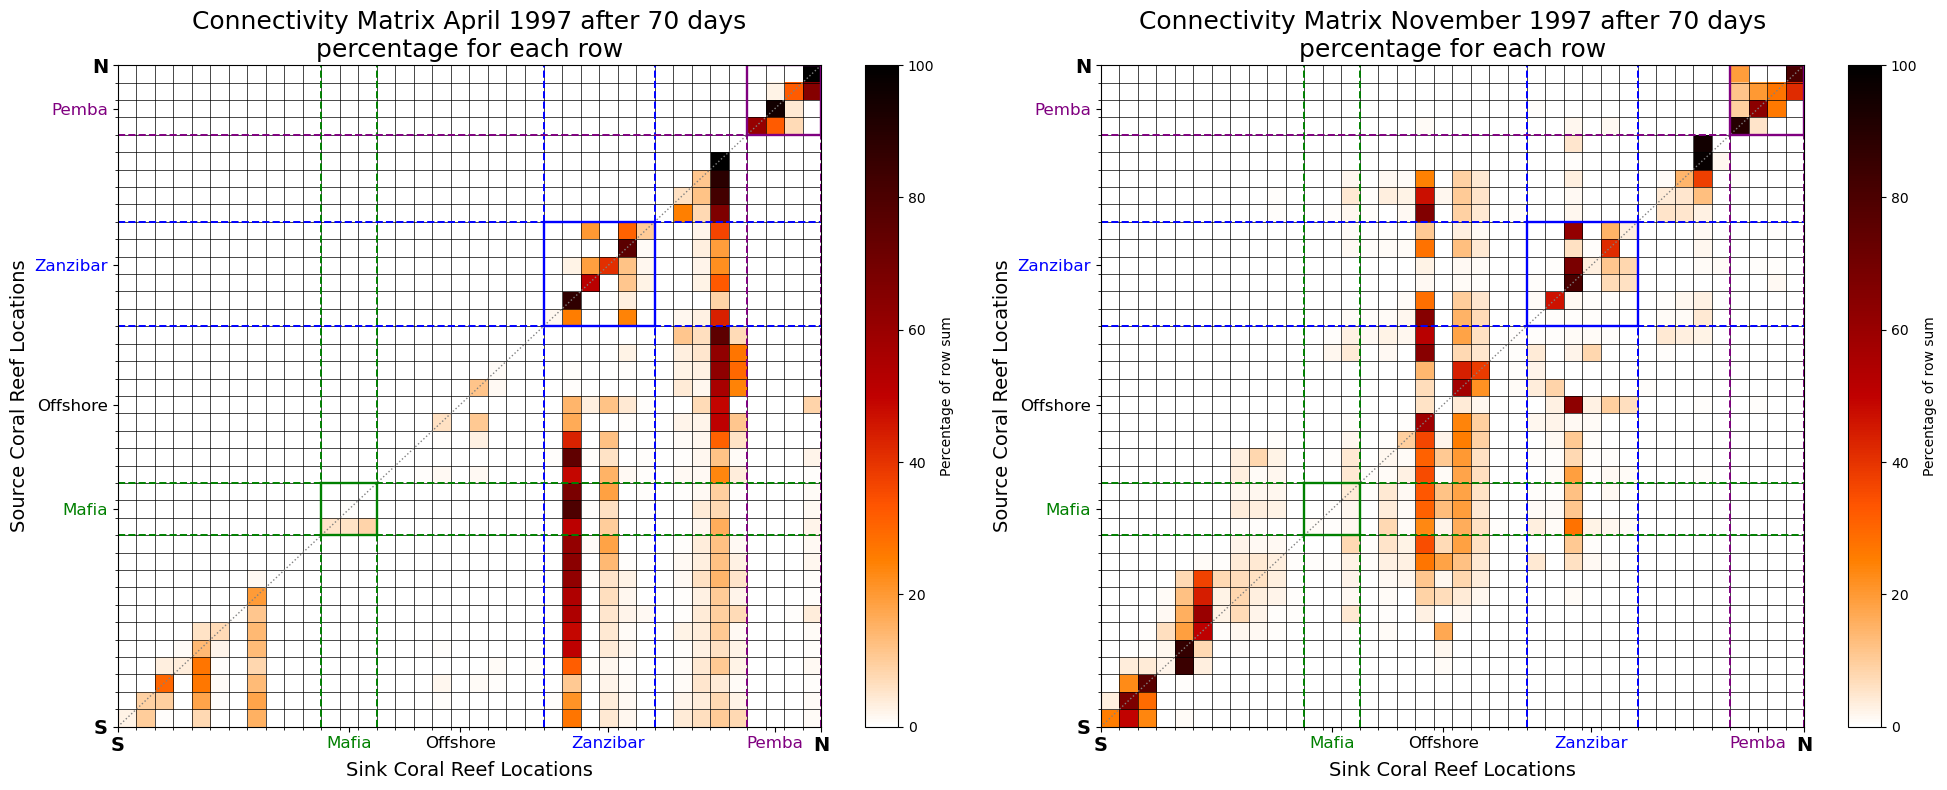

In [55]:
cmap = 'gist_heat_r'
vmax = 100
vmin = 0
specific_ticks = [-0.5, 12, 18, 26, 35, 37.5]
tick_labels = ['S', 'Mafia', 'Offshore', 'Zanzibar', 'Pemba', 'N']
tick_colors = {'S': 'black', 'Mafia': 'g', 'Offshore': 'k', 'Zanzibar': 'b', 'Pemba': 'purple', 'N': 'black'}
Mafia = [11, 14]
Zanzibar = [23, 29]
Pemba_rows = [34, 38]

fig, axs = plt.subplots(1, 2, figsize=(20, 8))

def plot_connectivity_matrix(ax, matrix, title):
    im = ax.imshow(matrix, cmap=cmap, interpolation='nearest', aspect='auto', vmax=vmax, vmin=vmin)
    ax.invert_yaxis()
    ax.set_title(title, fontsize=18)
    ax.set_xlabel('Sink Coral Reef Locations', fontsize=14)
    ax.set_ylabel('Source Coral Reef Locations', fontsize=14)
    ax.grid(which='minor', color='k', linestyle='-', linewidth=0.5)
    ax.set_xticks(np.arange(-0.5, 38.5, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, 38.5, 1), minor=True)
    ax.plot([-0.5, 37.5], [-0.5, 37.5], color='grey', linewidth=1, linestyle='dotted')

   
    for row in Mafia:
        ax.axhline(y=row - 0.5, color='g', linewidth=1.4, linestyle='--')
        ax.axhline(y=row - 0.5, xmin=11/38, xmax=14/38, color='g', linewidth=1.7, linestyle='-')
        ax.axvline(x=row - 0.5, color='g', linewidth=1.4, linestyle='--')
        ax.axvline(x=row - 0.5, ymin=11/38, ymax=14/38, color='g', linewidth=1.7, linestyle='-')
    
    for row in Zanzibar:
        ax.axhline(y=row - 0.5, color='b', linewidth=1.4, linestyle='--')
        ax.axhline(y=row - 0.5, xmin=23/38, xmax=29/38, color='b', linewidth=1.7, linestyle='-')
        ax.axvline(x=row - 0.5, color='b', linewidth=1.4, linestyle='--')
        ax.axvline(x=row - 0.5, ymin=23/38, ymax=29/38, color='b', linewidth=1.7, linestyle='-')

    for row in Pemba_rows:
        ax.axhline(y=row - 0.5, color='purple', linewidth=1.4, linestyle='--')
        ax.axhline(y=row - 0.5, xmin=34/38, xmax=38/38, color='purple', linewidth=1.7, linestyle='-')
        ax.axvline(x=row - 0.5, color='purple', linewidth=1.4, linestyle='--')
        ax.axvline(x=row - 0.5, ymin=34/38, ymax=38/38, color='purple', linewidth=1.7, linestyle='-')    
    
    ax.set_xticks(ticks=specific_ticks, labels=tick_labels, rotation=0)
    ax.set_yticks(ticks=specific_ticks, labels=tick_labels, rotation=0)

    for label in ax.get_xticklabels():
        text = label.get_text()
        if text in tick_colors:
            label.set_fontsize(12)
            label.set_color(tick_colors[text])
            if text in ['S', 'N']:
                label.set_fontsize(14)
                label.set_fontweight('bold')

    for label in ax.get_yticklabels():
        text = label.get_text()
        if text in tick_colors:
            label.set_fontsize(12)
            label.set_color(tick_colors[text])
            if text in ['S', 'N']:
                label.set_fontsize(14)
                label.set_fontweight('bold')

plot_connectivity_matrix(axs[0], connectivity_matrix_April97_70days, 'Connectivity Matrix April 1997 after 70 days\npercentage for each row')
plot_connectivity_matrix(axs[1], connectivity_matrix_November97_70days, 'Connectivity Matrix November 1997 after 70 days\npercentage for each row')

for ax in axs:
    fig.colorbar(ax.get_images()[0], ax=ax, label='Percentage of row sum')

plt.tight_layout()

filename=f'/mnt/iscsi2/OceanParcels/OBS_Figures/Apr_vs_Nov_1997_70.png'
plt.savefig(filename)